In [220]:
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import inv
from scipy.special import gammaln
import pandas as pd
import statsmodels.api as sm
from scipy.stats import gamma
import matplotlib.pyplot as plt
import scipy.io

In [221]:
#Set initial parameters for hyperpriors
maxlambda = 50
minlambda = 0.0001

maxphi = 50
minphi = 0.00001

In [222]:
#Coefficients of a Gamma distribution, used for the hyperpriors
def GammaCoef(mode, sd):
    k = (2+(mode**2)/(sd**2) + np.sqrt((4+(mode**2)/(sd**2))*(mode**2)/(sd**2)))/ 2
    theta = np.sqrt(sd**2/k)
    r = (k, theta)
    return r

#Likelihood for a Gamma distribution
def logPhipdf(x, k, theta):
    return (k-1)*np.log(x) - x/theta - k*np.log(theta) - gammaln(k)

In [223]:
#Defining the likelihood function
def logMLbvar(par, y, x, lags, T, n, b, SS, pos, HH, y0, PLR, lambdamod, lambdasd, Phimod, Phisd):
    d = n+2
    
    lambda_ = minlambda + (maxlambda - minlambda) / (1 + np.exp(-par[0]))
    alpha = 2
    Phi = np.zeros(n)
    
    if PLR == 1 :
        for j in range(n):
            Phi[j] = minphi + (maxphi-minphi)/(1+np.exp(-par[1]))
        
    #Setting up the priors
    k = 1 + n*lags
    omega = np.zeros(k)
    omega[0] = 10e6

    for i in range(1, lags + 1):
        omega[1+(i-1)*n:1+i*n] = (d-n-1)*(lambda_**2)*(1/(i**alpha))/SS

    #Prior scale matrix for the covariance of the shocks
    PSI = np.diag(SS)

    ydlr = []
    xdlr = []
    
    #For long-run priors
    if PLR == 1 :
        rHH = HH.shape[0]  #rank of HH
        y0H = np.dot(y0, HH.T)
        HH_1 = inv(HH)

        #Prepare dummy observations
        Td = 0
        cont = 0
    
        for j in range(n):
            if j < rHH:
                Phitemp = Phi[j]
                scale = y0H[j]/Phitemp
                ydtemp = scale*HH_1[:, j].T
                xdtemp = np.hstack([np.zeros(1), scale*np.tile(HH_1[:, j].T, (1, lags)).flatten()])
    
            else :
                Phitemp = Phi[j]
                J = range(rHH+1, n)
                ydtemp = (np.dot(HH_1[:, J], np.dot(HH[J, :], y0.T))).T/Phitemp
                xdtemp = np.hstack([1/Phitemp, np.tile((np.dot(HH_1[:, J], np.dot(HH[J, :], y0.T))).T, (1, lags)).flatten()/Phitemp])
                
            ydlr.append(ydtemp)
            xdlr.append(xdtemp)
    
        #Add long-run priors to data and regressors
        y = np.vstack([y, np.array(ydlr)])
        x = np.vstack([x, np.array(xdlr)])
        Td += len(xdlr)
        T += Td

    #Compute posterior mode of VAR coefficients

    betahat = np.linalg.solve(x.T@x + np.diag(1/omega), x.T@y + np.diag(1/omega)@b)
    epshat = y - x@betahat #residuals
    sigmahat = (epshat.T@epshat + PSI + (betahat-b).T@np.diag(1/omega)@(betahat-b))/(T+d+n+1)

    #Log marginal likelihood (logML)
    A = np.diag(np.sqrt(omega))@(x.T@x)@np.diag(np.sqrt(omega))
    B = np.diag(1/np.sqrt(SS))@(epshat.T@epshat+(betahat-b).T@np.diag(1/omega)@(betahat-b))@np.diag(1/np.sqrt(SS))

    eigA = np.real(np.linalg.eigvals(A))
    eigA[eigA < 1e-12] = 0
    eigA = eigA+1

    eigB = np.real(np.linalg.eigvals(B))
    eigB[eigB < 1e-12] = 0
    eigB = eigB + 1

    logML = -n*T*np.log(np.pi)/2 + np.sum(gammaln((T+d-np.arange(n))/2) - gammaln((d-np.arange(n))/2)) - \
        T*np.sum(np.log(SS))/2 - n*np.sum(np.log(eigA))/2 - (T+d)*np.sum(np.log(eigB))/2

    #Long-run prior adjustment
    if len(ydlr) != 0:
        yd = np.array(ydlr)
        xd = np.array(xdlr)
        
        #Prior mode of the VAR coefficients
        betahatd = b
        
        #VAR residuals at the prior mode
        epshatd = yd - xd@betahatd
        
        A = np.diag(np.sqrt(omega))@(xd.T@xd)@np.diag(np.sqrt(omega))
        B = np.diag(1/np.sqrt(SS))@(epshatd.T@epshatd + (betahatd-b).T@np.diag(1/omega)@(betahatd-b))@np.diag(1/np.sqrt(SS))
        
        eigA = np.real(np.linalg.eigvals(A))
        eigA[eigA < 1e-12] = 0
        eigA = eigA+1
    
        eigB = np.real(np.linalg.eigvals(B))
        eigB[eigB < 1e-12] = 0
        eigB = eigB + 1
        
        #Normalizing constant
        norm = -n*Td*np.log(np.pi)/2 + np.sum(gammaln((Td+d-np.arange(n))/2) - gammaln((d-np.arange(n))/2)) - \
                Td*np.sum(np.log(SS))/2 - n*np.sum(np.log(eigA))/2 - (T+d)*np.sum(np.log(eigB))/2
        
        logML -= norm

    #Initializing the priors for lambda and Phi
    lambdaprior = GammaCoef(lambdamod, lambdasd)
    Phiprior = GammaCoef(Phimod, Phisd)
    
    logML += logPhipdf(lambda_, lambdaprior[0], lambdaprior[1])

    if PLR == 1 :
        for j in range(n):
            logML += logPhipdf(Phi[j], Phiprior[0], Phiprior[1])
    
    #Return negative log-likelihood (logML)
    return -logML, betahat, sigmahat, lambda_, Phi, HH

#Objective function for the minimization
def objective_function(par, y, x, lags, T, n, b, SS, pos, HH, y0, PLR, lambdamod, lambdasd, Phimod, Phisd):
    res, _, _, _, _, _ = logMLbvar(par, y, x, lags, T, n, b, SS, pos, HH, y0, PLR, lambdamod, lambdasd, Phimod, Phisd)
    return res

In [224]:
def lag(arr,i,n):
    return(np.concatenate((np.zeros((i,n)),arr),axis=0)[:-i, :]) 

def bvar(y, lags, HH, PLR, lambdamod, lambdasd, Phimod = 1, Phisd = 1):
    pos = []
    TT, n = y.shape
    k = n*lags + 1  #number of coefficients for each equation
    
    #Constructing the matrix of regressors
    x = np.zeros((TT, k))
    x[:, 0] = 1
    for i in range(1, lags+1):
        x[:, (i-1)*n+1: i*n+1] = lag(y,i,n)
    
    #Mean of the first 'lags' observations
    y0 = np.mean(y[:lags, :], axis=0)
    x = x[lags:, :]
    y = y[lags:, :]
    TT, n = y.shape
    
    #MN prior mean
    b = np.zeros((k, n))
    diagb = np.ones(n)
    diagb[pos] = 0  #set to zero the prior mean on the first own lag for variables selected in pos
    b[1:n+1, :] = np.diag(diagb)
    
    #Starting values for the minimization
    lambda0 = 0.2
    Phi0 = 1
    
    #Residual variance of AR(1) for each variable
    SS = np.zeros(n)

    for i in range(n):
        X = np.column_stack([np.ones(TT - 1), y[:-1, i]])
        y_ = y[1:, i]
        X_ = sm.add_constant(X)
    
        model = sm.OLS(y_, X_)
        results = model.fit()
    
        SS[i] = results.scale
    
    #Initial guess for the optimization
    if PLR == 1 :
        x0 = np.concatenate([[-np.log((maxlambda - lambda0)/(lambda0 - minlambda))], -np.log((maxphi - Phi0)/(Phi0 - minphi))*np.ones(n)])

    else :
        x0 = [-np.log((maxlambda - lambda0) / (lambda0 - minlambda))]
    
    args = (y, x, lags, TT, n, b, SS, pos, HH, y0, PLR, lambdamod, lambdasd, Phimod, Phisd)
    
    #Maximization of the posterior of the hyperparameters
    result = minimize(objective_function, x0, args=args, method='BFGS', jac=None, options={'gtol': 1e-10, 'maxiter': 1000})

    #Results
    xh = result.x
    itct = result.nit
    
    #Output of the maximization
    fh, betahat, sigmahat, lambda_hat, Phi_hat, HH = logMLbvar(xh, y, x, lags, TT, n, b, SS, pos, HH, y0, PLR, lambdamod, lambdasd, Phimod, Phisd)
    
    r = {'lags': lags,
         'postmax': {
            'betahat': betahat,
            'sigmahat': sigmahat,
            'lambda': lambda_hat,
            'Phi': Phi_hat,
            'logPost': -fh,
            'SSar1': SS,},
        'HH': HH}

    #Forecasts at the posterior mode
    if Fcast == 1:
        Y = np.vstack([y, np.zeros((max(nbtrimpred), n))])
        for tau in range(0, max(nbtrimpred)):
            xT = np.concatenate([np.ones(1), Y[TT+tau-1: TT+tau-lags-1 :-1, :].reshape(-1)])
            Y[TT+tau , :] = xT@betahat

        r['postmax']['forecast'] = Y[TT-1+np.array(nbtrimpred), :]
    
    return r

Processing time: 51
Processing time: 52
Processing time: 53
Processing time: 54
Processing time: 55
Processing time: 56
Processing time: 57
Processing time: 58
Processing time: 59
Processing time: 60
Processing time: 61
Processing time: 62
Processing time: 63
Processing time: 64
Processing time: 65
Processing time: 66
Processing time: 67
Processing time: 68
Processing time: 69
Processing time: 70
Processing time: 71
Processing time: 72
Processing time: 73
Processing time: 74
Processing time: 75
Processing time: 76
Processing time: 77
Processing time: 78
Processing time: 79
Processing time: 80
Processing time: 81
Processing time: 82
Processing time: 83
Processing time: 84
Processing time: 85
Processing time: 86
Processing time: 87
Processing time: 88
Processing time: 89
Processing time: 90
Processing time: 91
Processing time: 92
Processing time: 93
Processing time: 94
Processing time: 95
Processing time: 96
Processing time: 97
Processing time: 98
Processing time: 99
Processing time: 100

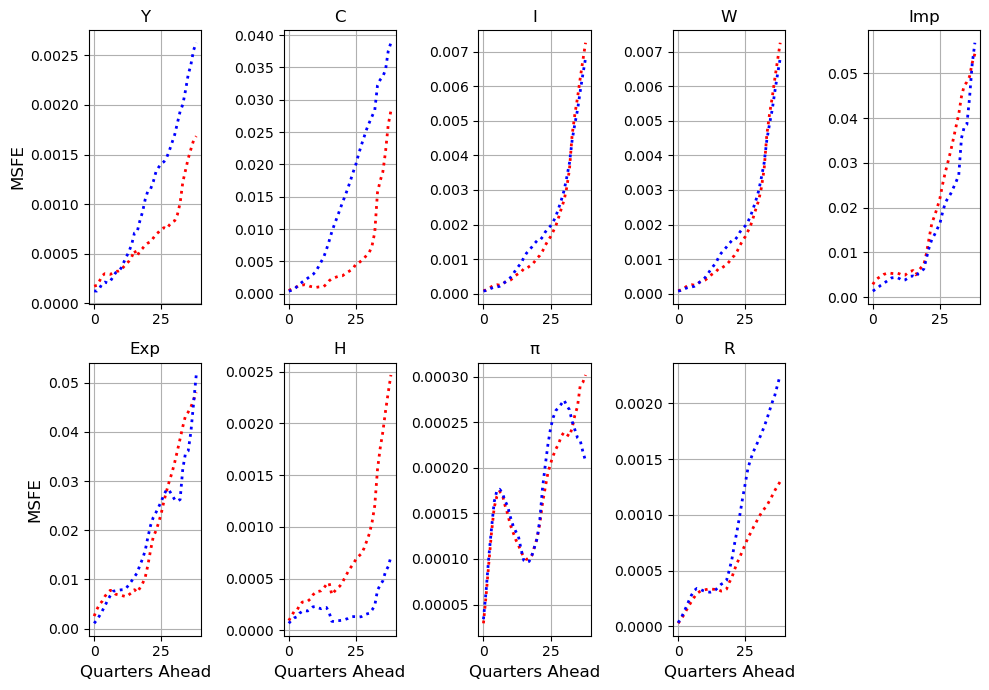

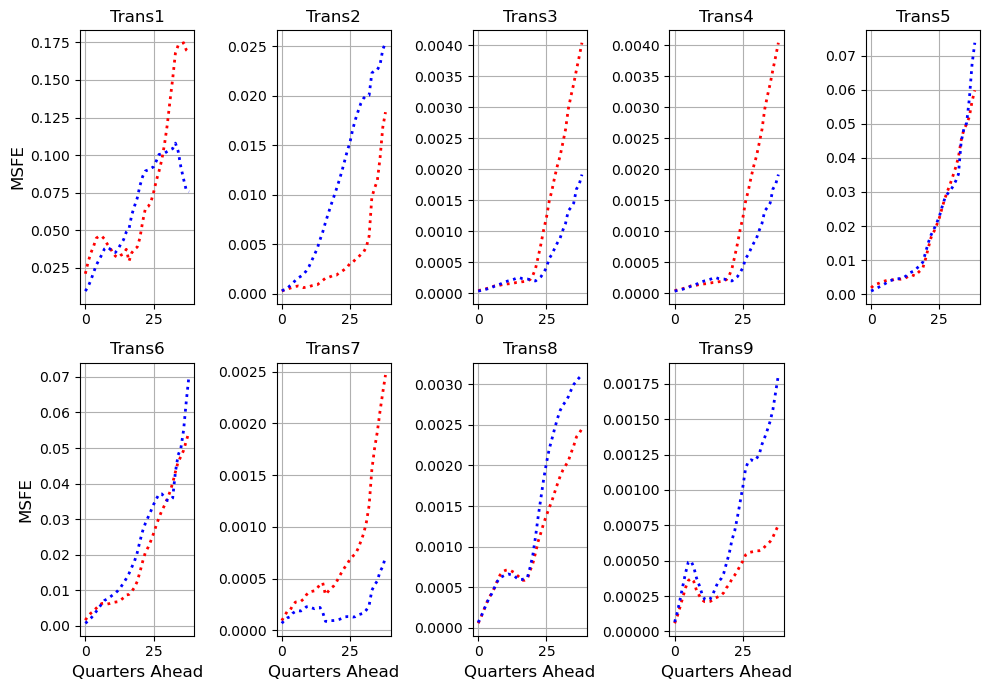

In [260]:
#Replication and new data

#Set parameters
lags = 5
nbtrimpred = range(1,41) #forecasting horizons in quarters
Fcast = 1

#Choose the data to use
data = 'logger' #Either 'mat', 'logger' or 'log'

if data == 'mat' : 
    mat_file = 'y.mat'
    data_file = scipy.io.loadmat(mat_file)
    variable_name = 'y'
    y = np.array(data_file[variable_name])
    
    HH = np.array([
        [ 1,  1,  1,  0,  1,  0,  0],  # Y + C + I + W
        [-1,  1,  0,  0,  0,  0,  0],  # C - Y
        [-1,  0,  1,  0,  0,  0,  0],  # I - Y
        [ 0,  0,  0,  1,  0,  0,  0],  # W - Y
        [-1,  0,  0,  0,  1,  0,  0],  # H
        [ 0,  0,  0,  0,  0,  1,  1],  # π + R
        [ 0,  0,  0,  0,  0, -1,  1]   # R - π 
    ])
    
    variables = ['Y', 'C', 'I', 'W', 'H', 'π', 'R'] 
    transformations = ['Y + C + I + W', 'C - Y', 'I - Y', 'W - Y', 'H', 'π + R', 'R - π ']
    ini = 81

elif data == 'logger' :
    y = np.array(pd.read_csv("Ylogger.csv",sep=";"))
    
    HH = np.array([
        [ 1,  1,  1,  1,  1,  1,  0,  0,  0],  
        [-1,  1,  0,  0,  0,  0,  0,  0,  0], 
        [-1,  0,  1,  0,  0,  0,  0,  0,  0], 
        [-1,  0,  0,  1,  0,  0,  0,  0,  0], 
        [-1,  0,  0,  0,  1,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0, -1,  1]
    ])

    variables = ['Y', 'C', 'I', 'W','Imp','Exp', 'H', 'π', 'R']
    transformations = ['Trans1', 'Trans2', 'Trans3', 'Trans4', 'Trans5', 'Trans6', 'Trans7', 'Trans8', 'Trans9']
    ini = 51

elif data == 'log' :
    y = np.array(pd.read_csv("Ylog.csv",sep=";"))

    HH = np.array([
        [ 1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], 
        [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1]
    ])

    variables = ['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'Var9',
    'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15', 'Var16', 'Var17', 'Var18']
    transformations = ['Trans1', 'Trans2', 'Trans3', 'Trans4', 'Trans5', 'Trans6', 'Trans7', 'Trans8', 'Trans9',
    'Trans10', 'Trans11', 'Trans12', 'Trans13', 'Trans14', 'Trans15', 'Trans16', 'Trans17', 'Trans18']
    ini = 51

#Parameters of hyperpriors
lambdamod1 = 1 #Modes coming from Gamma distribution
lambdamod2 = 0.2
Phimod1 = 1
Phimod2 = 1

lambdasd1 = 1 #Standard errors
lambdasd2 = 0.4
Phisd1 = 1
Phisd2 = 1

#Forecasting loop
T, n = y.shape
YfcastPLR1 = np.zeros((T, max(nbtrimpred), n))
YfcastPLR2 = np.zeros((T, max(nbtrimpred), n))
YfcastMN = np.zeros((T, max(nbtrimpred), n))

for t in range(ini, T):
    print(f"Processing time: {t}")
    rPLR1 = bvar(y[:t, :], lags, HH, 1, lambdamod1, lambdasd1, Phimod1, Phisd1)
    #rPLR2 = bvar(y[:t, :], lags, HH, 1, lambdamod2, lambdasd2, Phimod2, Phisd2)
    rMN = bvar(y[:t, :], lags, HH, 0, lambdamod2, lambdasd2)
    YfcastPLR1[t, :, :] = rPLR1['postmax']['forecast']
    YfcastPLR2[t, :, :] = rPLR2['postmax']['forecast']
    YfcastMN[t, :, :] = rMN['postmax']['forecast']

#MSFE computation
MSFEPLR1 = np.zeros((len(nbtrimpred)-1, n))
MSFELCPLR1 = np.zeros((len(nbtrimpred)-1, n))
#MSFEPLR2 = np.zeros((len(nbtrimpred)-1, n))
#MSFELCPLR2 = np.zeros((len(nbtrimpred)-1, n))
MSFEMN = np.zeros((len(nbtrimpred)-1, n))
MSFELCMN = np.zeros((len(nbtrimpred)-1, n))

for h in range(1, max(nbtrimpred)):
    DYfcastPLR1 = YfcastPLR1[ini-h+max(nbtrimpred): -h, h, :] - y[ini-h+max(nbtrimpred): -h, :]
    #DYfcastPLR2 = YfcastPLR2[ini-h+max(nbtrimpred): -h, h, :] - y[ini-h+max(nbtrimpred): -h, :]
    DYfcastMN = YfcastMN[ini-h+max(nbtrimpred): -h, h, :] - y[ini-h+max(nbtrimpred): -h, :]
    DY = y[ini+max(nbtrimpred):, :] - y[ini-h+max(nbtrimpred): -h, :]
    DYfcastPLR1DY = DYfcastPLR1 - DY
    #DYfcastPLR2DY = DYfcastPLR2 - DY
    DYfcastMNDY = DYfcastMN - DY

    MSFEPLR1[h-1, :] = np.mean(DYfcastPLR1DY**2, axis=0)
    #MSFEPLR2[h-1, :] = np.mean(DYfcastPLR2DY**2, axis=0)
    MSFEMN[h-1, :] = np.mean(DYfcastMNDY**2, axis=0)

    DYfcastLCPLR1 = (YfcastPLR1[ini-h+max(nbtrimpred): -h, h, :] - y[ini-h+max(nbtrimpred): -h, :]*0)@HH.T
    #DYfcastLCPLR2 = (YfcastPLR2[ini-h+max(nbtrimpred): -h, h, :] - y[ini-h+max(nbtrimpred): -h, :]*0)@HH.T
    DYfcastLCMN = (YfcastMN[ini-h+max(nbtrimpred): -h, h, :] - y[ini-h+max(nbtrimpred): -h, :]*0)@HH.T
    DYLC = (y[ini+max(nbtrimpred):, :] - y[ini-h+max(nbtrimpred): -h, :]*0)@HH.T
    DYfcastPLR1DYLC = DYfcastLCPLR1 - DYLC
    #DYfcastPLR2DYLC = DYfcastLCPLR2 - DYLC
    DYfcastMNDYLC = DYfcastLCMN - DYLC

    MSFELCPLR1[h-1, :] = np.mean(DYfcastPLR1DYLC**2, axis=0)
    #MSFELCPLR2[h-1, :] = np.mean(DYfcastPLR2DYLC**2, axis=0)
    MSFELCMN[h-1, :] = np.mean(DYfcastMNDYLC**2, axis=0)

#Setting plot parameters
colorPLR1 = 'r'
colorPLR2 = 'g'
colorMN = 'b'
LS = ':'
LW = 2
col = (n+1)//2

#Plotting the MSFE for the variables
plt.figure(figsize=(12, 7))
for i in range(n):
    plt.subplot(2, col, i+1)
    plt.plot(MSFEPLR1[:, i], color=colorPLR1, linestyle=LS, linewidth=LW)
    #plt.plot(MSFEPLR2[:, i], color=colorPLR2, linestyle=LS, linewidth=LW)
    plt.plot(MSFEMN[:, i], color=colorMN, linestyle=LS, linewidth=LW)
    plt.title(variables[i])
    if i in [0, col]:
        plt.ylabel('MSFE', fontsize=12)
    if i >= col:
        plt.xlabel('Quarters Ahead', fontsize=12)
    plt.grid(True)
plt.tight_layout()
plt.show()

#Plotting the MSFE for the transformed variables
plt.figure(figsize=(12, 7))
for i in range(n):
    plt.subplot(2, col, i+1)
    plt.plot(MSFELCPLR1[:, i], color=colorPLR1, linestyle=LS, linewidth=LW)
    #plt.plot(MSFELCPLR2[:, i], color=colorPLR2, linestyle=LS, linewidth=LW)
    plt.plot(MSFELCMN[:, i], color=colorMN, linestyle=LS, linewidth=LW)
    plt.title(transformations[i])
    if i in [0, col]:
        plt.ylabel('MSFE', fontsize=12)
    if i >= col:
        plt.xlabel('Quarters Ahead', fontsize=12)
    plt.grid(True)
plt.tight_layout()
plt.show()

In [226]:
#Changing prior for US data might me ignored : results in

#Set parameters
lags = 5
nbtrimpred = range(1,41) #forecasting horizons in quarters
Fcast = 1

#Choose the data to use
data = 'mat' #Either 'mat', 'logger' or 'log'

if data == 'mat' : 
    mat_file = 'y.mat'
    data_file = scipy.io.loadmat(mat_file)
    variable_name = 'y'
    y = np.array(data_file[variable_name])
    
    HH = np.array([
        [ 1,  1,  1,  0,  1,  0,  0],  # Y + C + I + W
        [-1,  1,  0,  0,  0,  0,  0],  # C - Y
        [-1,  0,  1,  0,  0,  0,  0],  # I - Y
        [ 0,  0,  0,  1,  0,  0,  0],  # W - Y
        [-1,  0,  0,  0,  1,  0,  0],  # H
        [ 0,  0,  0,  0,  0,  1,  1],  # π + R
        [ 0,  0,  0,  0,  0, -1,  1]   # R - π 
    ])
    
    variables = ['Y', 'C', 'I', 'W', 'H', 'π', 'R'] 
    transformations = ['Y + C + I + W', 'C - Y', 'I - Y', 'W - Y', 'H', 'π + R', 'R - π ']
    ini = 81

elif data == 'logger' :
    y = np.array(pd.read_csv("Ylogger.csv",sep=";"))
    
    HH = np.array([
        [ 1,  1,  1,  1,  1,  1,  0,  0,  0],  
        [-1,  1,  0,  0,  0,  0,  0,  0,  0], 
        [-1,  0,  1,  0,  0,  0,  0,  0,  0], 
        [-1,  0,  0,  1,  0,  0,  0,  0,  0], 
        [-1,  0,  0,  0,  1,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0, -1,  1]
    ])

    variables = ['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'Var9']
    transformations = ['Trans1', 'Trans2', 'Trans3', 'Trans4', 'Trans5', 'Trans6', 'Trans7', 'Trans8', 'Trans9']
    ini = 51

elif data == 'log' :
    y = np.array(pd.read_csv("Ylog.csv",sep=";"))

    HH = np.array([
        [ 1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], 
        [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1]
    ])

    variables = ['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'Var9',
    'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15', 'Var16', 'Var17', 'Var18']
    transformations = ['Trans1', 'Trans2', 'Trans3', 'Trans4', 'Trans5', 'Trans6', 'Trans7', 'Trans8', 'Trans9',
    'Trans10', 'Trans11', 'Trans12', 'Trans13', 'Trans14', 'Trans15', 'Trans16', 'Trans17', 'Trans18']
    ini = 51

#Parameters of hyperpriors
lambdamod = [0.5,0.1,0.2,0.4,0.8] #Modes coming from Gamma distribution
Phimod = [0.2,0.5,1,2,4]
Lmd = 0.2
lambdasd = [0.1,0.2,0.4,0.8,2] #Standard errors
Phisd = [0.2,0.5,1,2,4]
Lsd = 0.4

#Forecasting loop
T, n = y.shape
YfcastPLRus = np.zeros((5,5,T, max(nbtrimpred), n))
YfcastMNus = np.zeros((5,5,T, max(nbtrimpred), n))

for i in range(5):
    lsd = lambdasd[i]
    psd = Phisd[i]
    for j in range(5):
        lmd = lambdamod[j]
        pmd = Phimod[j]
        print(f"Processing rank: {i,j}")
        for t in range(ini, T):
#            rMN = bvar(y[:t, :], lags, HH, 0, lmd, lsd)
#            YfcastMNus[i,j,t, :, :] = rMN['postmax']['forecast']
            rPLR = bvar(y[:t, :], lags, HH, 1, lmd, lsd, pmd, psd)
            YfcastPLRus[i,j,t, :, :] = rPLR['postmax']['forecast']


Processing rank: (0, 0)
Processing rank: (0, 1)
Processing rank: (0, 2)
Processing rank: (0, 3)
Processing rank: (0, 4)
Processing rank: (1, 0)
Processing rank: (1, 1)
Processing rank: (1, 2)
Processing rank: (1, 3)
Processing rank: (1, 4)
Processing rank: (2, 0)
Processing rank: (2, 1)
Processing rank: (2, 2)
Processing rank: (2, 3)
Processing rank: (2, 4)
Processing rank: (3, 0)
Processing rank: (3, 1)
Processing rank: (3, 2)
Processing rank: (3, 3)
Processing rank: (3, 4)
Processing rank: (4, 0)
Processing rank: (4, 1)
Processing rank: (4, 2)
Processing rank: (4, 3)
Processing rank: (4, 4)


In [227]:
#Changing prior for German data

#Set parameters
lags = 5
nbtrimpred = range(1,41) #forecasting horizons in quarters
Fcast = 1

#Choose the data to use
data = 'logger' #Either 'mat', 'logger' or 'log'
variablesger = ['Y', 'C', 'I', 'W','Imp','Exp', 'H', 'π', 'R']
variables = ['Y', 'C', 'I', 'H', 'W', 'π', 'R'] 

if data == 'mat' : 
    mat_file = 'y.mat'
    data_file = scipy.io.loadmat(mat_file)
    variable_name = 'y'
    y = np.array(data_file[variable_name])
    
    HH = np.array([
        [ 1,  1,  1,  0,  1,  0,  0],  # Y + C + I + W
        [-1,  1,  0,  0,  0,  0,  0],  # C - Y
        [-1,  0,  1,  0,  0,  0,  0],  # I - Y
        [ 0,  0,  0,  1,  0,  0,  0],  # W - Y
        [-1,  0,  0,  0,  1,  0,  0],  # H
        [ 0,  0,  0,  0,  0,  1,  1],  # π + R
        [ 0,  0,  0,  0,  0, -1,  1]   # R - π 
    ])
    
    transformations = ['Y + C + I + W', 'C - Y', 'I - Y', 'W - Y', 'H', 'π + R', 'R - π ']
    ini = 81

elif data == 'logger' :
    y = np.array(pd.read_csv("Ylogger.csv",sep=";"))
    
    HH = np.array([
        [ 1,  1,  1,  1,  1,  1,  0,  0,  0],  
        [-1,  1,  0,  0,  0,  0,  0,  0,  0], 
        [-1,  0,  1,  0,  0,  0,  0,  0,  0], 
        [-1,  0,  0,  1,  0,  0,  0,  0,  0], 
        [-1,  0,  0,  0,  1,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0, -1,  1]
    ])

    transformations = ['Trans1', 'Trans2', 'Trans3', 'Trans4', 'Trans5', 'Trans6', 'Trans7', 'Trans8', 'Trans9']
    ini = 51

elif data == 'log' :
    y = np.array(pd.read_csv("Ylog.csv",sep=";"))

    HH = np.array([
        [ 1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], 
        [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1]
    ])

    variables = ['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'Var9',
    'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15', 'Var16', 'Var17', 'Var18']
    transformations = ['Trans1', 'Trans2', 'Trans3', 'Trans4', 'Trans5', 'Trans6', 'Trans7', 'Trans8', 'Trans9',
    'Trans10', 'Trans11', 'Trans12', 'Trans13', 'Trans14', 'Trans15', 'Trans16', 'Trans17', 'Trans18']
    ini = 51

#Parameters of hyperpriors
lambdamod = [0.5,0.1,0.2,0.4,0.8] #Modes coming from Gamma distribution
Phimod = [0.2,0.5,1,2,4]

lambdasd = [0.1,0.2,0.4,0.8,2] #Standard errors
Phisd = [0.2,0.5,1,2,4]

#Forecasting loop
T, n = y.shape
YfcastPLRger = np.zeros((5,5,T, max(nbtrimpred), n))
YfcastMNger = np.zeros((5,5,T, max(nbtrimpred), n))

for i in range(5):
    lsd = lambdasd[i]
    psd = Phisd[i]
    for j in range(5):
        lmd = lambdamod[j]
        pmd = Phimod[j]
        print(f"Processing rank: {i,j}")
        for t in range(ini, T):
#            rMN = bvar(y[:t, :], lags, HH, 0, lmd, lsd)
#            YfcastMNger[i,j,t, :, :] = rMN['postmax']['forecast']
            rPLR = bvar(y[:t, :], lags, HH, 1, lmd, lsd, pmd, psd)
            YfcastPLRger[i,j,t, :, :] = rPLR['postmax']['forecast']


Processing rank: (0, 0)
Processing rank: (0, 1)
Processing rank: (0, 2)
Processing rank: (0, 3)
Processing rank: (0, 4)
Processing rank: (1, 0)
Processing rank: (1, 1)
Processing rank: (1, 2)
Processing rank: (1, 3)
Processing rank: (1, 4)
Processing rank: (2, 0)
Processing rank: (2, 1)
Processing rank: (2, 2)
Processing rank: (2, 3)
Processing rank: (2, 4)
Processing rank: (3, 0)
Processing rank: (3, 1)
Processing rank: (3, 2)
Processing rank: (3, 3)
Processing rank: (3, 4)
Processing rank: (4, 0)
Processing rank: (4, 1)
Processing rank: (4, 2)
Processing rank: (4, 3)
Processing rank: (4, 4)


In [228]:
#np.save('compa_YfcastMNger.npy', YfcastMNger)
#np.save('compa_YfcastMNus.npy', YfcastMNus)
np.save('compa_YfcastPLRger.npy', YfcastPLRger)
np.save('compa_YfcastPLRus.npy', YfcastPLRus)

In [199]:
#YfcastMNger = np.load('comp_YfcastMNger.npy')
#YfcastMNus = np.load('comp_YfcastMNus.npy')
YfcastPLRger = np.load('compa_YfcastPLRger.npy')
YfcastPLRus = np.load('compa_YfcastPLRus.npy')

In [262]:
MSFEPLRger = np.zeros((5,5,len(nbtrimpred)-1, 9))
#MSFEMNger = np.zeros((5,5,len(nbtrimpred)-1, 9))
MSFEPLRus = np.zeros((5,5,len(nbtrimpred)-1, 7))
#MSFEMNus = np.zeros((5,5,len(nbtrimpred)-1, 7))

yger = np.array(pd.read_csv("Ylogger.csv",sep=";"))
mat_file = 'y.mat'
data_file = scipy.io.loadmat(mat_file)
variable_name = 'y'
yus = np.array(data_file[variable_name])
inius = 81
iniger = 51

for i in range(5):
    for j in range(5):
        for h in range(1, max(nbtrimpred)):
#            DYfcastMNger = YfcastMNger[i,j,iniger-h+max(nbtrimpred): -h, h, :] - yger[iniger-h+max(nbtrimpred): -h, :]
#            DYger = yger[iniger+max(nbtrimpred):, :] - yger[iniger-h+max(nbtrimpred): -h, :]
#            DYfcastMNDYger = DYfcastMNger - DYger
#            MSFEMNger[i,j,h-1, :] = np.mean(DYfcastMNDYger**2, axis=0)
#            DYfcastMNus = YfcastMNus[i,j,inius-h+max(nbtrimpred): -h, h, :] - yus[inius-h+max(nbtrimpred): -h, :]
#            DYus = yus[inius+max(nbtrimpred):, :] - yus[inius-h+max(nbtrimpred): -h, :]
#            DYfcastMNDYus = DYfcastMNus - DYus
#            MSFEMNus[i,j,h-1, :] = np.mean(DYfcastMNDYus**2, axis=0)
            DYfcastPLRger = YfcastPLRger[i,j,iniger-h+max(nbtrimpred): -h, h, :] - yger[iniger-h+max(nbtrimpred): -h, :]
            DYger = yger[iniger+max(nbtrimpred):, :] - yger[iniger-h+max(nbtrimpred): -h, :]
            DYfcastPLRDYger = DYfcastPLRger - DYger
            MSFEPLRger[i,j,h-1, :] = np.mean(DYfcastPLRDYger**2, axis=0)
            DYfcastPLRus = YfcastPLRus[i,j,inius-h+max(nbtrimpred): -h, h, :] - yus[inius-h+max(nbtrimpred): -h, :]
            DYus = yus[inius+max(nbtrimpred):, :] - yus[inius-h+max(nbtrimpred): -h, :]
            DYfcastPLRDYus = DYfcastPLRus - DYus
            MSFEPLRus[i,j,h-1, :] = np.mean(DYfcastPLRDYus**2, axis=0)
                    
np.save('compa_MSFEMNger.npy', MSFEMNger)
np.save('compa_MSFEMNus.npy', MSFEMNus)
np.save('compa_MSFEPLRger.npy', MSFEPLRger)
np.save('compa_MSFEPLRus.npy', MSFEPLRus)

In [231]:
MSFEPLRgerl = np.zeros((5,5,len(nbtrimpred)-1, 9))
#MSFEMNgerl = np.zeros((5,5,len(nbtrimpred)-1, 9))
MSFEPLRusl = np.zeros((5,5,len(nbtrimpred)-1, 7))
#MSFEMNusl = np.zeros((5,5,len(nbtrimpred)-1, 7))

yger = np.array(pd.read_csv("Ylogger.csv",sep=";"))
mat_file = 'y.mat'
data_file = scipy.io.loadmat(mat_file)
variable_name = 'y'
yus = np.array(data_file[variable_name])
iniusp = 101
inigerp = 71

for i in range(5):
    for j in range(5):
        for h in range(1, max(nbtrimpred)):
#            DYfcastMNger = YfcastMNger[i,j,iniger-h+max(nbtrimpred): -h, h, :] - yger[iniger-h+max(nbtrimpred): -h, :]
#            DYger = yger[iniger+max(nbtrimpred):, :] - yger[iniger-h+max(nbtrimpred): -h, :]
#            DYfcastMNDYger = DYfcastMNger - DYger
#            MSFEMNgerl[i,j,h-1, :] = np.mean(DYfcastMNDYger**2, axis=0)
#            DYfcastMNus = YfcastMNus[i,j,inius-h+max(nbtrimpred): -h, h, :] - yus[inius-h+max(nbtrimpred): -h, :]
#            DYus = yus[inius+max(nbtrimpred):, :] - yus[inius-h+max(nbtrimpred): -h, :]
#            DYfcastMNDYus = DYfcastMNus - DYus
#            MSFEMNusl[i,j,h-1, :] = np.mean(DYfcastMNDYus**2, axis=0)
            DYfcastPLRger = YfcastPLRger[i,j,inigerp-h+max(nbtrimpred): -h, h, :] - yger[inigerp-h+max(nbtrimpred): -h, :]
            DYger = yger[inigerp+max(nbtrimpred):, :] - yger[inigerp-h+max(nbtrimpred): -h, :]
            DYfcastPLRDYger = DYfcastPLRger - DYger
            MSFEPLRgerl[i,j,h-1, :] = np.mean(DYfcastPLRDYger**2, axis=0)
            DYfcastPLRus = YfcastPLRus[i,j,iniusp-h+max(nbtrimpred): -h, h, :] - yus[iniusp-h+max(nbtrimpred): -h, :]
            DYus = yus[iniusp+max(nbtrimpred):, :] - yus[iniusp-h+max(nbtrimpred): -h, :]
            DYfcastPLRDYus = DYfcastPLRus - DYus
            MSFEPLRusl[i,j,h-1, :] = np.mean(DYfcastPLRDYus**2, axis=0)
                    
np.save('compa_MSFEMNgerl.npy', MSFEMNgerl)
np.save('compa_MSFEMNusl.npy', MSFEMNusl)
np.save('compa_MSFEPLRgerl.npy', MSFEPLRgerl)
np.save('compa_MSFEPLRusl.npy', MSFEPLRusl)

In [237]:
#meanMSFEMNger = np.mean(MSFEMNger, axis=(2, 3))
meanMSFEPLRger = np.mean(MSFEPLRger, axis=(2, 3))
#meanMSFEMNus = np.mean(MSFEMNus, axis=(2, 3))
meanMSFEPLRus = np.mean(MSFEPLRus, axis=(2, 3))
#meanMSFEMNgerl = np.mean(MSFEMNgerl, axis=(2, 3))
meanMSFEPLRgerl = np.mean(MSFEPLRgerl, axis=(2, 3))
#meanMSFEMNusl = np.mean(MSFEMNusl, axis=(2, 3))
meanMSFEPLRusl = np.mean(MSFEPLRusl, axis=(2, 3))

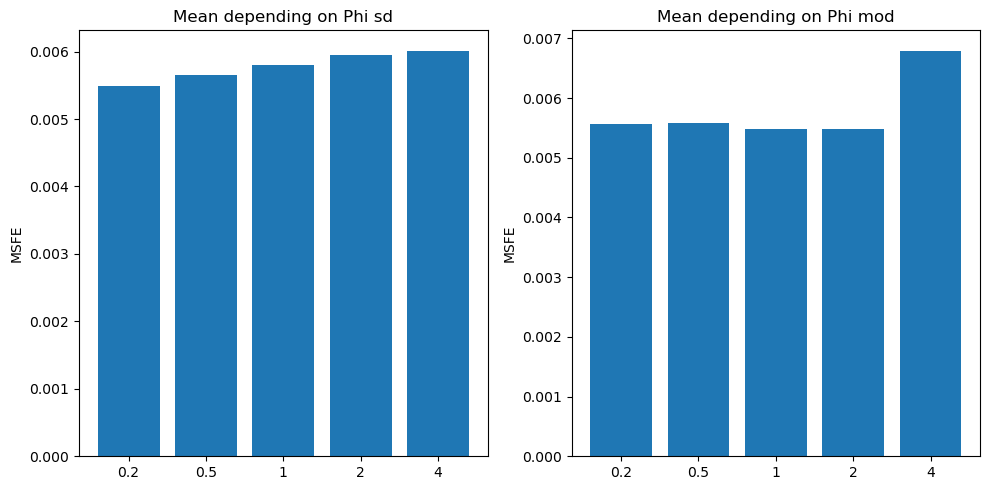

In [246]:
mean_dim0 = np.mean(meanMSFEPLRger, axis=(1))  # Moyenne selon la première dimension (shape 3, 4, 3)
mean_dim1 = np.mean(meanMSFEPLRger, axis=(0))  # Moyenne selon la deuxième dimension (shape 4, 4, 3)

# Créer des graphiques à barres pour chaque moyenne
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
lambdamod = [0.5,0.1,0.2,0.4,0.8] #Modes coming from Gamma distribution
Phimod = [0.2,0.5,1,2,4]

lambdasd = [0.1,0.2,0.4,0.8,2] #Standard errors
Phisd = [0.2,0.5,1,2,4]
# Moyenne selon la dimension 0
axes[0].bar(range(len(mean_dim0)), mean_dim0)
axes[0].set_title('Mean depending on Phi sd')
axes[0].set_xticks(range(5))
axes[0].set_xticklabels(['0.2','0.5','1','2','4']) 
axes[0].set_ylabel('MSFE')

# Moyenne selon la dimension 1
axes[1].bar(range(len(mean_dim1)), mean_dim1)
axes[1].set_title('Mean depending on Phi mod')
axes[1].set_xticks(range(5))
axes[1].set_xticklabels(['0.2','0.5','1','2','4']) 
axes[1].set_ylabel('MSFE')
plt.tight_layout()
plt.show()


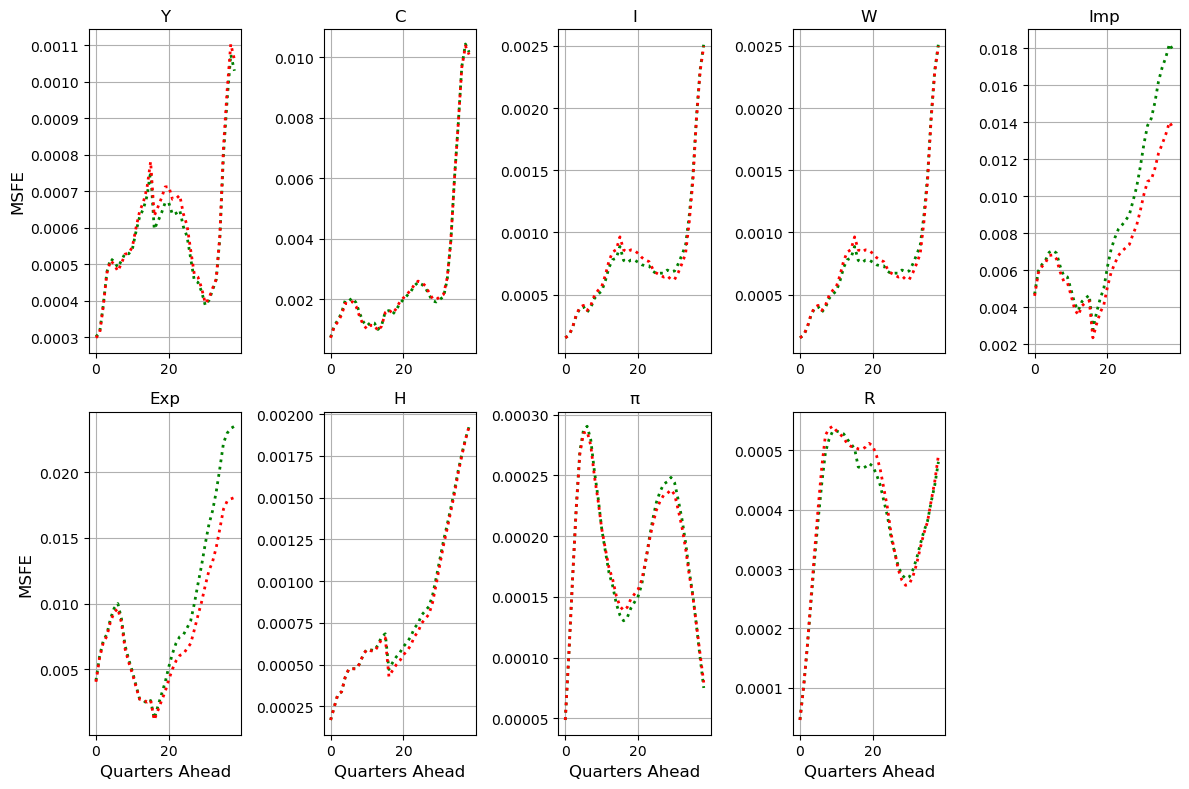

In [241]:
YfcastPLRgerbest = np.mean(YfcastPLRger[:2,2:3,:,:,:], axis = (0,1))
YfcastPLRgerbase = YfcastPLRger[2,2,:,:,:]
MSFEPLRgerlbase = np.zeros((len(nbtrimpred)-1, 9))
MSFEPLRgerlbest = np.zeros((len(nbtrimpred)-1, 9))

for h in range(1, max(nbtrimpred)):
    DYfcastPLRger = YfcastPLRgerbest[inigerp-h+max(nbtrimpred): -h, h, :] - yger[inigerp-h+max(nbtrimpred): -h, :]
    DYger = yger[inigerp+max(nbtrimpred):, :] - yger[inigerp-h+max(nbtrimpred): -h, :]
    DYfcastPLRDYger = DYfcastPLRger - DYger
    MSFEPLRgerlbest[h-1, :] = np.mean(DYfcastPLRDYger**2, axis=0)
    DYfcastPLRger = YfcastPLRgerbase[inigerp-h+max(nbtrimpred): -h, h, :] - yger[inigerp-h+max(nbtrimpred): -h, :]
    DYger = yger[inigerp+max(nbtrimpred):, :] - yger[inigerp-h+max(nbtrimpred): -h, :]
    DYfcastPLRDYger = DYfcastPLRger - DYger
    MSFEPLRgerlbase[h-1, :] = np.mean(DYfcastPLRDYger**2, axis=0)

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(2, col, i+1)
    plt.plot(MSFEPLRgerlbase[:, i], color='g', linestyle=LS, linewidth=LW)
    plt.plot(MSFEPLRgerlbest[:, i], color='r', linestyle=LS, linewidth=LW)
    plt.title(variablesger[i])
    if i in [0, col]:
        plt.ylabel('MSFE', fontsize=12)
    if i >= col:
        plt.xlabel('Quarters Ahead', fontsize=12)
    plt.grid(True)
plt.tight_layout()
plt.show()

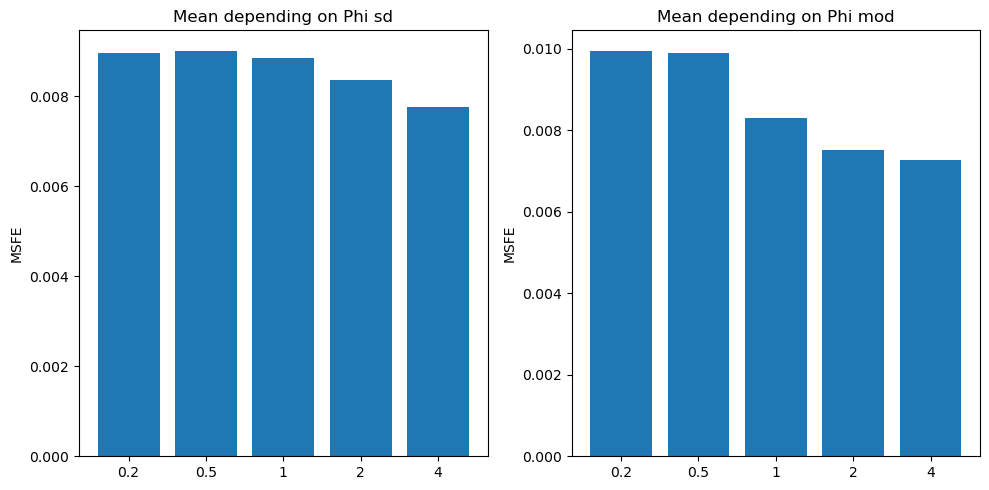

In [247]:
mean_dim0 = np.mean(meanMSFEPLRus, axis=(1))  # Moyenne selon la première dimension (shape 3, 4, 3)
mean_dim1 = np.mean(meanMSFEPLRus, axis=(0))  # Moyenne selon la deuxième dimension (shape 4, 4, 3)

# Créer des graphiques à barres pour chaque moyenne
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
lambdamod = [0.5,0.1,0.2,0.4,0.8] #Modes coming from Gamma distribution
Phimod = [0.2,0.5,1,2,4]

lambdasd = [0.1,0.2,0.4,0.8,2] #Standard errors
Phisd = [0.2,0.5,1,2,4]
# Moyenne selon la dimension 0
axes[0].bar(range(len(mean_dim0)), mean_dim0)
axes[0].set_title('Mean depending on Phi sd')
axes[0].set_xticks(range(5))
axes[0].set_xticklabels(['0.2','0.5','1','2','4']) 
axes[0].set_ylabel('MSFE')

# Moyenne selon la dimension 1
axes[1].bar(range(len(mean_dim1)), mean_dim1)
axes[1].set_title('Mean depending on Phi mod')
axes[1].set_xticks(range(5))
axes[1].set_xticklabels(['0.2','0.5','1','2','4']) 
axes[1].set_ylabel('MSFE')
plt.tight_layout()
plt.show()


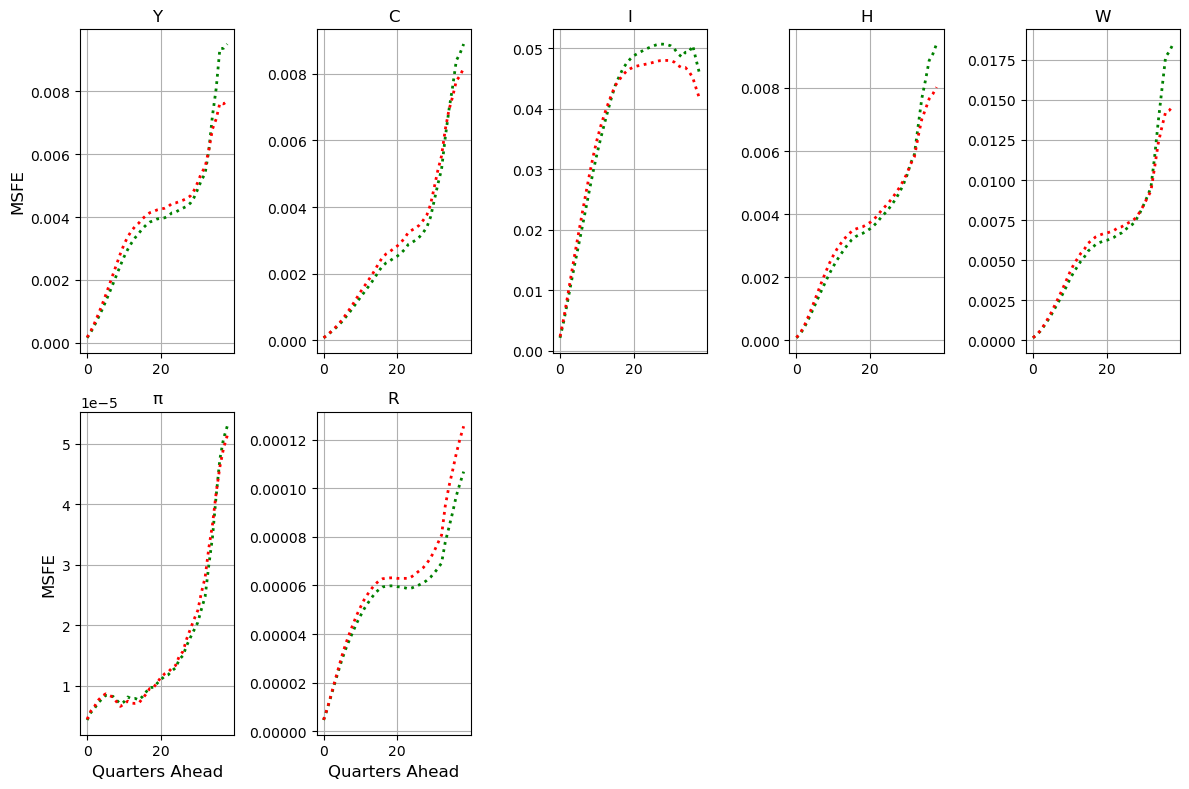

In [256]:
YfcastPLRusbest = np.mean(YfcastPLRus[2:,2:,:,:,:], axis = (0,1))
YfcastPLRusbase = YfcastPLRus[2,2,:,:,:]
MSFEPLRuslbase = np.zeros((len(nbtrimpred)-1, 7))
MSFEPLRuslbest = np.zeros((len(nbtrimpred)-1, 7))

for h in range(1, max(nbtrimpred)):
    DYfcastPLRus = YfcastPLRusbest[iniusp-h+max(nbtrimpred): -h, h, :] - yus[iniusp-h+max(nbtrimpred): -h, :]
    DYus = yus[iniusp+max(nbtrimpred):, :] - yus[iniusp-h+max(nbtrimpred): -h, :]
    DYfcastPLRDYus = DYfcastPLRus - DYus
    MSFEPLRuslbest[h-1, :] = np.mean(DYfcastPLRDYus**2, axis=0)
    DYfcastPLRus = YfcastPLRusbase[iniusp-h+max(nbtrimpred): -h, h, :] - yus[iniusp-h+max(nbtrimpred): -h, :]
    DYus = yus[iniusp+max(nbtrimpred):, :] - yus[iniusp-h+max(nbtrimpred): -h, :]
    DYfcastPLRDYus = DYfcastPLRus - DYus
    MSFEPLRuslbase[h-1, :] = np.mean(DYfcastPLRDYus**2, axis=0)

plt.figure(figsize=(12, 8))
for i in range(7):
    plt.subplot(2, col, i+1)
    plt.plot(MSFEPLRuslbase[:, i], color='g', linestyle=LS, linewidth=LW)
    plt.plot(MSFEPLRuslbest[:, i], color='r', linestyle=LS, linewidth=LW)
    plt.title(variables[i])
    if i in [0, col]:
        plt.ylabel('MSFE', fontsize=12)
    if i >= col:
        plt.xlabel('Quarters Ahead', fontsize=12)
    plt.grid(True)
plt.tight_layout()
plt.show()